# Assignment 2b Notebook: Automated Design of AI Agents with Genetic Programming
In this assignment, you will further iterate on to your Assignment 2a implementation of random parse tree generation to realize a full genetic programming (GP) implementation. Like Assignment Series 1, you will leverage components you've already implemented in this assignment. From your previous assignment implementations, copy over the following files:
* base_evolution.py
* selection.py
* tree_genotype.py

As usual, be careful not to overwrite any of the provided files that may have been modified since previous assignments. To begin the assignment, execute the following cell. **If you implemented your genotype in a new file, be sure to import it in the next cell!**

In [48]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from snake_eyes import read_config
from fitness import play_GPac
from selection import *
from tree_genotype import *
from parse_tree import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('The first cell has been executed!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The first cell has been executed!


## Recombination
Assuming you've correctly implemented population initialization in Assignment 2a, we'll begin this assignment by implementing recombination with subtree crossover. Like Assignment Series 1, your recombination method should take a mate as input and recombine the genes of `self` and `mate`, assign the recombination to the `gene` member variable of `child` and then return child. Recall that you should somehow enforce a configurable maximum tree depth throughout this assignment and this applies to children produced with recombination and mutation.

How you implement subtree crossover in practice depends on your implementation of the parse tree gene and is thus open-ended. Implement `TreeGenotype.recombine` and test your implementation by executing the following cell.

In [49]:
import random

# read config
config = read_config('./configs/green2b_config.txt', globalVars=globals(), localVars=locals())

# initialize population
random_population = TreeGenotype.initialization(25, **config['initialization_kwargs'])

# perform recombination
children = list()
for idx in range(len(random_population)):
    child = random_population[idx].recombine(random_population[(idx+1)%len(random_population)],
                                             **config['recombination_kwargs'])


    children.append(child)


# print recombined trees to files
for idx, individual in enumerate(children):
    with open(f'treeTests/tree{idx}r.txt','w') as f:
        f.write(individual.print())
            
del random_population, children, config

# evaluate tree files
!python tree_check.py treeTests/tree*r.txt

treeTests/tree0r.txt: PASS
treeTests/tree10r.txt: PASS
treeTests/tree11r.txt: PASS
treeTests/tree12r.txt: PASS
treeTests/tree13r.txt: PASS
treeTests/tree14r.txt: PASS
treeTests/tree15r.txt: PASS
treeTests/tree16r.txt: PASS
treeTests/tree17r.txt: PASS
treeTests/tree18r.txt: PASS
treeTests/tree19r.txt: PASS
treeTests/tree1r.txt: PASS
treeTests/tree20r.txt: PASS
treeTests/tree21r.txt: PASS
treeTests/tree22r.txt: PASS
treeTests/tree23r.txt: PASS
treeTests/tree24r.txt: PASS
treeTests/tree2r.txt: PASS
treeTests/tree3r.txt: PASS
treeTests/tree4r.txt: PASS
treeTests/tree5r.txt: PASS
treeTests/tree6r.txt: PASS
treeTests/tree7r.txt: PASS
treeTests/tree8r.txt: PASS
treeTests/tree9r.txt: PASS


## Mutation
Recall that mutation in GP is mutually exclusive with recombination. That is to say that mutation in GP is used to directly produce children by mutating a copy of the parent.

Using your parse tree gene implementation, implement subtree mutation in `TreeGenotype.mutate` and test your implementation by executing the next cell. Don't forget to enforce max tree depth like in recombination!

In [50]:
# read config
config = read_config('./configs/green2b_config.txt', globalVars=globals(), localVars=locals())

# initialize population
random_population = TreeGenotype.initialization(25, **config['initialization_kwargs'])

# perform mutation
children = list()
for individual in random_population:
    children.append(individual.mutate(**config['mutation_kwargs']))

# print mutated trees to files
for idx, individual in enumerate(children):
    with open(f'treeTests/tree{idx}m.txt','w') as f:
        f.write(individual.print())
del random_population, children, config

# evaluate tree files
!python tree_check.py treeTests/tree*m.txt

treeTests/tree0m.txt: PASS
treeTests/tree10m.txt: PASS
treeTests/tree11m.txt: PASS
treeTests/tree12m.txt: PASS
treeTests/tree13m.txt: PASS
treeTests/tree14m.txt: PASS
treeTests/tree15m.txt: PASS
treeTests/tree16m.txt: PASS
treeTests/tree17m.txt: PASS
treeTests/tree18m.txt: PASS
treeTests/tree19m.txt: PASS
treeTests/tree1m.txt: PASS
treeTests/tree20m.txt: PASS
treeTests/tree21m.txt: PASS
treeTests/tree22m.txt: PASS
treeTests/tree23m.txt: PASS
treeTests/tree24m.txt: PASS
treeTests/tree2m.txt: PASS
treeTests/tree3m.txt: PASS
treeTests/tree4m.txt: PASS
treeTests/tree5m.txt: PASS
treeTests/tree6m.txt: PASS
treeTests/tree7m.txt: PASS
treeTests/tree8m.txt: PASS
treeTests/tree9m.txt: PASS


## Implementing Genetic Programming
By this point, you should have a complete implementation of your genotype and we can turn our attention to implementing the complete GP algorithm.

### Evaluation and Parsimony Pressure
Recall from the lecture and videos by Dr. Koza that GP tends to produce individual genotypes of increasing size without a mechanism to curb this. You will implement a parsimony penalty to encourage your GP to produce more compact trees (in addition to the depth limits you already have). With this mechanism of parsimony pressure, you will penalize the fitness of a solution based on their size. $fitness(i)=raw\_fitness(i)-C_p*size(i)$ where $C_p$ is a parsimony coefficient from your config file and $size(i)$ is a function that returns the size of individual $i$. The two most obvious metrics of tree size are tree depth and node count, but you are encouraged with experiments to use the size metric that performs best.

**Note**: The implementation of a parsimony penalty is nearly identical to the penalty-based constraint satisfaction method you implemented in Assignment 1c. Like Assignment 1c, *it is not meaningful to compare penalized fitness with unpenalized fitness* and we require that you use penalized fitness for evolution and raw fitness for analysis.

In the file `gpac_population_evaluation.py`, implement the `basic_population_evaluation` function that performs fitness evaluations on an input population using the input configuration parameters and assigns parsimony-penalized fitness, raw fitness, and saves the log of the fitness evaluation. Now test your implementation by executing the following cell.

In [11]:
from gpac_population_evaluation import basic_population_evaluation
import statistics

config = read_config('./configs/green2b_config.txt', globalVars=globals(), localVars=locals())

example_population = TreeGenotype.initialization(25, **config['initialization_kwargs'])
for individual in example_population:
    individual.raw_fitness = None
    individual.log = None

# calling your function to test things out (this function is called the same as in notebook 1c)
basic_population_evaluation(example_population, **config['fitness_kwargs'])

missing = len([True for individual in example_population if individual.fitness is None])
print(f'Individuals with unassigned (penalized) fitness: {missing}')
raw_missing = len([True for individual in example_population if individual.raw_fitness is None])
print(f'Individuals with unassigned raw fitness: {raw_missing}')
print(f'Number of complete fitness evaluations performed: {len(example_population) - max(missing, raw_missing)}')
if missing == 0 and raw_missing == 0:
    fitnesses = [individual.fitness for individual in example_population]
    print(f'Average fitness of population: {statistics.mean(fitnesses)}')
    print(f'Best fitness in population: {max(fitnesses)}')
    raw_fitnesses = [individual.raw_fitness for individual in example_population]
    print(f'Average raw fitness of population: {statistics.mean(raw_fitnesses)}')
    print(f'Best unpenalized (raw) fitness in population: {max(raw_fitnesses)}')
    best_log = max(example_population, key=lambda ind: ind.fitness).log

    print(f'Found log of highest scoring individual? {best_log is not None}')
    game_log_path = 'worldFiles/testParsimony.txt'
    with open(game_log_path, 'w') as f:
        [f.write(f'{line}\n') for line in best_log]

    print(f"The log of the most fit individual was written to {game_log_path}")
else:
    print('Ensure the entire population is evaluated then execute this cell again')

del example_population, config

Individuals with unassigned (penalized) fitness: 0
Individuals with unassigned raw fitness: 0
Number of complete fitness evaluations performed: 25
Average fitness of population: -815.96
Best fitness in population: 8
Average raw fitness of population: 9.44
Best unpenalized (raw) fitness in population: 53
Found log of highest scoring individual? True
The log of the most fit individual was written to worldFiles/testParsimony.txt


### Child Generation
With fitness evaluation implemented, we can now perform parent selection and move to implementing child generation with the `GeneticProgrammingPopulation` class. This class inherits the `BaseEvolutionPopulation` class from last assignment and should be able to directly use the inherited initialization and survival selection methods without modification. Child generation is different in GP, as mentioned previously in this notebook, so you need to implement the GP version of `generate_children` in the `GeneticProgrammingPopulation` class. Once complete, test your implementation in the following cell.

In [12]:
from genetic_programming import *

config = read_config('./configs/green2b_config.txt', globalVars=globals(), localVars=locals())

# full initialization of your GP population
example_EA = GeneticProgrammingPopulation(**config['EA_configs'], **config)
basic_population_evaluation(example_EA.population, **config['fitness_kwargs'])
example_EA.evaluations = len(example_EA.population)
fitnesses = [individual.fitness for individual in example_EA.population]
print(f'Average fitness of population: {statistics.mean(fitnesses)}')
print(f'Best fitness in population: {max(fitnesses)}')
print(f'Number of fitness evaluations: {example_EA.evaluations}')

# generate children
children = example_EA.generate_children()
basic_population_evaluation(children, **config['fitness_kwargs'])
example_EA.evaluations += len(children)
children_fitnesses = [individual.fitness for individual in children]
print(f'Average fitness of children: {statistics.mean(children_fitnesses)}')
print(f'Best fitness of children: {max(children_fitnesses)}')
print(f'Number of fitness evaluations: {example_EA.evaluations}')

# print children trees to files
for idx, individual in enumerate(children):
    with open(f'treeTests/tree{idx}c.txt','w') as f:
        f.write(individual.print())
del example_EA, children, config, fitnesses, children_fitnesses

# evaluate tree files
!python tree_check.py treeTests/tree*c.txt

Average fitness of population: -816.38
Best fitness in population: 1
Number of fitness evaluations: 50
Average fitness of children: -5
Best fitness of children: -5
Number of fitness evaluations: 57
treeTests/tree0c.txt: PASS
treeTests/tree1c.txt: PASS
treeTests/tree2c.txt: PASS
treeTests/tree3c.txt: PASS
treeTests/tree4c.txt: PASS
treeTests/tree5c.txt: PASS
treeTests/tree6c.txt: PASS


## Single Run Experiment
At this point, you should have implemented the full GP algorithm to evolve GPac controllers! Now put all the components together and implement a single-run experiment with 2,000 fitness evaluations in the next cells.

In [13]:
from math import inf

# implement your GP here
def genetic_programming_search(number_evaluations, config_filename, run_number):
    best_fitness = -inf
    best_log = None
    best_tree = None
    data = []
    
    # Parse the config and implement your EA here.
    # Feel free to focus on implementation first and then return for data collection.
    
    config = read_config(config_filename, globalVars=globals(), localVars=locals())

    # full initialization of your GP population
    example_EA = GeneticProgrammingPopulation(**config['EA_configs'], **config)
    basic_population_evaluation(example_EA.population, **config['fitness_kwargs'])
    example_EA.evaluations = len(example_EA.population)
    fitnesses = [individual.fitness for individual in example_EA.population]
    
    data.append([statistics.mean(fitnesses), max(fitnesses)])
    
    # i've just been changing this for the different deliverable runs
    # instead of having multiple GP search functions that are basically the same
    if('green' in config_filename):
        with open('./data/green/run' + str(run_number) + 'Data.txt', 'w') as fp:
            fp.write(f'Number of Evaluations: {example_EA.evaluations}\n')
            fp.write(f'Best Fitness: {max(fitnesses)}\n')
            fp.write(f'Average Fitness: {statistics.mean(fitnesses)}\n')
            fp.write('------------------------\n')
    elif('yellow' in config_filename):
        with open('./data/yellow/depth_parsimony/run' + str(run_number) + 'Data.txt', 'w') as fp:
            fp.write(f'Number of Evaluations: {example_EA.evaluations}\n')
            fp.write(f'Best Fitness: {max(fitnesses)}\n')
            fp.write(f'Average Fitness: {statistics.mean(fitnesses)}\n')
            fp.write('------------------------\n')
    elif('red1' in config_filename):
        with open('./data/redOne/run' + str(run_number) + 'Data.txt', 'w') as fp:
            fp.write(f'Number of Evaluations: {example_EA.evaluations}\n')
            fp.write(f'Best Fitness: {max(fitnesses)}\n')
            fp.write(f'Average Fitness: {statistics.mean(fitnesses)}\n')
            fp.write('------------------------\n')
    
    #print(f'Average fitness of population: {statistics.mean(fitnesses)}')
    #print(f'Best fitness in population: {max(fitnesses)}')
    #print(f'Number of fitness evaluations: {example_EA.evaluations}')
    
    while not(example_EA.evaluations >= number_evaluations):
        
        # generate children
        children = example_EA.generate_children()
        basic_population_evaluation(children, **config['fitness_kwargs'])
        example_EA.evaluations += len(children)
        children_fitnesses = [individual.fitness for individual in children]
        
        if(max(children_fitnesses) > best_fitness):
            best_fitness = max(children_fitnesses)
            best_log = children[children_fitnesses.index(best_fitness)].log
            best_tree = children[children_fitnesses.index(best_fitness)]
            #print(f'\tNew best fitness: {best_fitness}')
            #print(f'\tRaw Fitness: {best_tree.raw_fitness}')
        
        data.append([statistics.mean(children_fitnesses), max(children_fitnesses)])
        
        if('green' in config_filename):
            with open('./data/green/run' + str(run_number) + 'Data.txt', 'a') as fp:
                fp.write(f'Number of Evaluations: {example_EA.evaluations}\n')
                fp.write(f'Best Fitness: {max(children_fitnesses)}\n')
                fp.write(f'Average Fitness: {statistics.mean(children_fitnesses)}\n')
                fp.write('------------------------\n')
        elif('yellow' in config_filename):
             with open('./data/yellow/depth_parsimony/run' + str(run_number) + 'Data.txt', 'w') as fp:
                fp.write(f'Number of Evaluations: {example_EA.evaluations}\n')
                fp.write(f'Best Fitness: {max(fitnesses)}\n')
                fp.write(f'Average Fitness: {statistics.mean(fitnesses)}\n')
                fp.write('------------------------\n')
        elif('red1' in config_filename):
            with open('./data/redOne/run' + str(run_number) + 'Data.txt', 'w') as fp:
                fp.write(f'Number of Evaluations: {example_EA.evaluations}\n')
                fp.write(f'Best Fitness: {max(fitnesses)}\n')
                fp.write(f'Average Fitness: {statistics.mean(fitnesses)}\n')
                fp.write('------------------------\n')
        
        
        #print(f'Average fitness of population: {statistics.mean(children_fitnesses)}')
        #print(f'Best fitness in population: {max(children_fitnesses)}')
        #print(f'Number of fitness evaluations: {example_EA.evaluations}')
        #print('-------------------')
            
    #game_log_path = 'worldFiles/testSingleRun.txt'
    #with open(game_log_path, 'w') as f:
    #    [f.write(f'{line}\n') for line in best_log]
        
    #print('Best Tree')
    #print(best_tree.print())
    
    overallAverageFitness = statistics.mean([gen[0] for gen in data])
    overallAverageBestFitness = statistics.mean([gen[1] for gen in data])
    
    return best_fitness, best_log, best_tree, overallAverageFitness, overallAverageBestFitness

In [42]:
# testing your implementation out
genetic_programming_search(2000, './configs/green2b_config.txt', 0)

(81,
 ['35',
  '20',
  'm 0 19',
  '0 34 0',
  '1 34 0',
  '2 34 0',
  'w 0 5',
  'w 0 6',
  'w 0 7',
  'w 0 8',
  'w 1 1',
  'w 1 2',
  'w 1 3',
  'w 1 10',
  'w 1 11',
  'w 1 12',
  'w 1 13',
  'w 1 15',
  'w 1 17',
  'w 1 18',
  'w 2 1',
  'w 2 5',
  'w 2 6',
  'w 2 7',
  'w 2 8',
  'w 2 13',
  'w 2 15',
  'w 2 17',
  'w 2 18',
  'w 3 1',
  'w 3 3',
  'w 3 4',
  'w 3 5',
  'w 3 6',
  'w 3 7',
  'w 3 8',
  'w 3 9',
  'w 3 10',
  'w 3 11',
  'w 3 13',
  'w 3 17',
  'w 3 18',
  'w 4 3',
  'w 4 4',
  'w 4 5',
  'w 4 6',
  'w 4 7',
  'w 4 8',
  'w 4 9',
  'w 4 10',
  'w 4 11',
  'w 4 15',
  'w 5 1',
  'w 5 2',
  'w 5 3',
  'w 5 4',
  'w 5 5',
  'w 5 6',
  'w 5 7',
  'w 5 8',
  'w 5 9',
  'w 5 10',
  'w 5 11',
  'w 5 12',
  'w 5 14',
  'w 5 15',
  'w 5 16',
  'w 5 18',
  'w 6 3',
  'w 6 4',
  'w 6 5',
  'w 6 6',
  'w 6 7',
  'w 6 8',
  'w 6 9',
  'w 6 10',
  'w 6 11',
  'w 6 12',
  'w 6 14',
  'w 6 15',
  'w 6 16',
  'w 6 18',
  'w 7 1',
  'w 7 3',
  'w 7 4',
  'w 7 5',
  'w 7 6',
  'w 7 

## Tuning
As is the case with all evolutionary algorithms, tuning your genetic programming algorithm is very important! In this case, it's also a graded component of the Algorithmic section of this assignment. As was the case with Assignment 1b, hand-tuning the algorithm parameters using a couple runs at a time is good enough for this class. Like Assignment 1b, you are expected to tune your algorithm parameters to a degree that your full GP outperforms the ramped half-and-half algorithm used in Assignment 2a (note that the default parameters are intentionally bad). While tuning, it can be helpful to ask yourself the following:
 * How many generations of evolution will occur based on $\mu$ and $\lambda$?
 * Is premature convergence occuring (e.g., max fitness is mediocre and does not increase)?
 * Is a loss of diversity preventing improvement (e.g., mean and best fitness approach convergence prematurely)?
 * If tuning $k$, is $k$-tournament actually being used as a selection method?
 * Have the problem instance or search space parameters been manipulated in a way that invalidates a comparison with ramped half-and-half (i.e., avoid manipulating the game parameters and tree depth limits)?
 * Is the parsimony coefficient tuned well? (Note: you'll need to consider this explicitly if attempting the YELLOW deliverable)

Use the following cell to tune the parameters in './configs/green2b_config.txt'.

Run # 0
Run # 1
Run # 2
Run # 3
Run # 4
Best Fitness 85
Best Tree
-
|+
||-
|||G
|||P
||-
|||P
|||P
|*
||RAND
|||P
|||M
||-
|||F
|||W



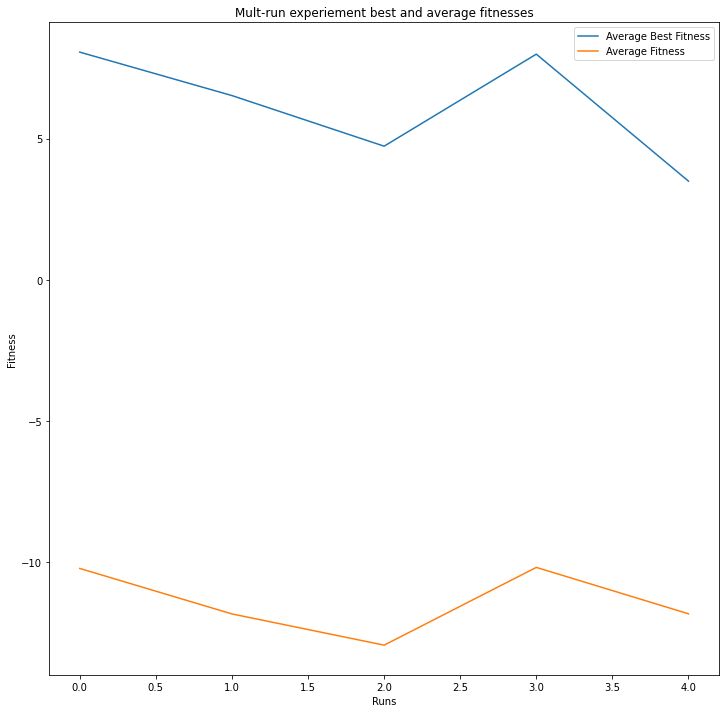

In [43]:
# feel free to change these values and re-run this cell as much as you'd like
number_runs = 5
number_evaluations = 2000
config_filename = './configs/green2b_config.txt'

runsData = list()

# tuning runs can be called here

for runCount in range(number_runs):
    print(f'Run # {runCount}')
    runsData.append(genetic_programming_search(2000, './configs/green2b_config.txt', runCount))
    
runsDataBestFitnesses = [runData[0] for runData in runsData]
overallBestFitness = max(runsDataBestFitnesses)
          
runsDataBestLogs = [runData[1] for runData in runsData]
overallBestLog = runsDataBestLogs[runsDataBestFitnesses.index(overallBestFitness)]
          
runsDataBestTrees = [runData[2] for runData in runsData]
overallBestTree = runsDataBestTrees[runsDataBestFitnesses.index(overallBestFitness)]

runsDataAveFitnesses = [runData[3] for runData in runsData]
runsDataAveBestFitnesses = [runData[4] for runData in runsData]


print(f'Best Fitness {overallBestFitness}')

game_log_path = 'worldFiles/tuningBest.txt'
with open(game_log_path, 'w') as f:
    [f.write(f'{line}\n') for line in overallBestLog]
          
print('Best Tree')
print(overallBestTree.print())

plt.figure()
plt.title(f'Mult-run experiement best and average fitnesses')
plt.xlabel('Runs')
plt.ylabel('Fitness')
plt.plot(range(number_runs), runsDataAveBestFitnesses, label="Average Best Fitness")
plt.plot(range(number_runs), runsDataAveFitnesses, label="Average Fitness")
plt.legend(loc="upper right")






## Multi-Run Experiments
Implement a full 30-run experiment with 2,000 fitness evaluations per run. For each generation, log the average fitness and best fitness of the current population. Average this data across all 30 runs to produce a plot of fitness vs evaluations with average and best fitness averaged across all 30 runs. For each run, log the best (unpenalized/raw) fitness encountered for statistical analysis with your results from Assignment 2a. For the individual with the highest fitness of the full 30-run experiment, save the log for visualization and informal analysis and comparison with the best agent from Assignment 2a.

Run # 0
Run # 1
Run # 2
Run # 3
Run # 4
Run # 5
Run # 6
Run # 7
Run # 8
Run # 9
Run # 10
Run # 11
Run # 12
Run # 13
Run # 14
Run # 15
Run # 16
Run # 17
Run # 18
Run # 19
Run # 20
Run # 21
Run # 22
Run # 23
Run # 24
Run # 25
Run # 26
Run # 27
Run # 28
Run # 29
Overall Best Fitness(penalized): 121


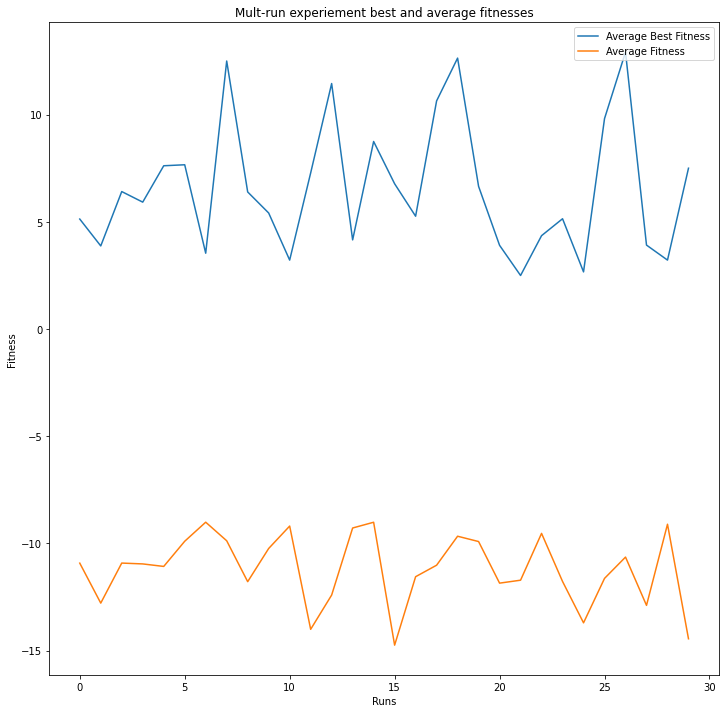

In [46]:
number_runs = 30
number_evaluations = 2000
config_filename = './configs/green2b_config.txt'

# Implement your 30-run experiment here

runsData = list()

# tuning runs can be called here

for runCount in range(number_runs):
    print(f'Run # {runCount}')
    runsData.append(genetic_programming_search(number_evaluations, config_filename, runCount))
    
runsDataBestFitnesses = [runData[0] for runData in runsData]
overallBestFitness = max(runsDataBestFitnesses)

runsDataBestRawFitnesses = [runData[2].raw_fitness for runData in runsData]
          
runsDataBestLogs = [runData[1] for runData in runsData]
overallBestLog = runsDataBestLogs[runsDataBestFitnesses.index(overallBestFitness)]
          
runsDataBestTrees = [runData[2] for runData in runsData]
overallBestTree = runsDataBestTrees[runsDataBestFitnesses.index(overallBestFitness)]

runsDataAveFitnesses = [runData[3] for runData in runsData]
runsDataAveBestFitnesses = [runData[4] for runData in runsData]

print(f'Overall Best Fitness(penalized): {overallBestFitness}')

game_log_path = 'worldFiles/overallGreenBest.txt'
with open(game_log_path, 'w') as f:
    [f.write(f'{line}\n') for line in overallBestLog]
          
#print('Best Tree')
#print(overallBestTree.print())
with open(f'solutions/bestGreenRunTree.txt','w') as f:
    f.write(overallBestTree.print())

with open('./data/green/bestRawFitnesses.txt', 'w') as fp:
    for fitness in runsDataBestRawFitnesses:
        fp.write(f'{fitness}\n')

plt.figure()
plt.title(f'Mult-run experiement best and average fitnesses')
plt.xlabel('Runs')
plt.ylabel('Fitness')
plt.plot(range(number_runs), runsDataAveBestFitnesses, label="Average Best Fitness")
plt.plot(range(number_runs), runsDataAveFitnesses, label="Average Fitness")
plt.legend(loc="upper right")




## Report
See Assignment Description Document for report details.

# YELLOW Deliverable
Now that you've completed the GREEN deliverable and conducted an experiment with one of the parsimony metrics (e.g., tree depth or tree size), experiment with the other metric and tune the parsimony coefficient. You are welcome to re-use the other parameters you used in your GREEN configuration, but some attempt at tuning the parsimony coefficient to account for the new parsimony metric is required.

***Note***: You should add a corresponding parameter to your config files that enables the selection of a parsimony metric.

Use the following 2 cells to tune and conduct a 30-run experiment, respectively:

Run # 0
Run # 1
Run # 2
Run # 3
Run # 4
Run # 5
Run # 6
Run # 7
Run # 8
Run # 9
Run # 10
Run # 11
Run # 12
Run # 13
Run # 14
Run # 15
Run # 16
Run # 17
Run # 18
Run # 19
Run # 20
Run # 21
Run # 22
Run # 23
Run # 24
Run # 25
Run # 26
Run # 27
Run # 28
Run # 29
Overall Best Fitness(penalized): 176
Best Tree


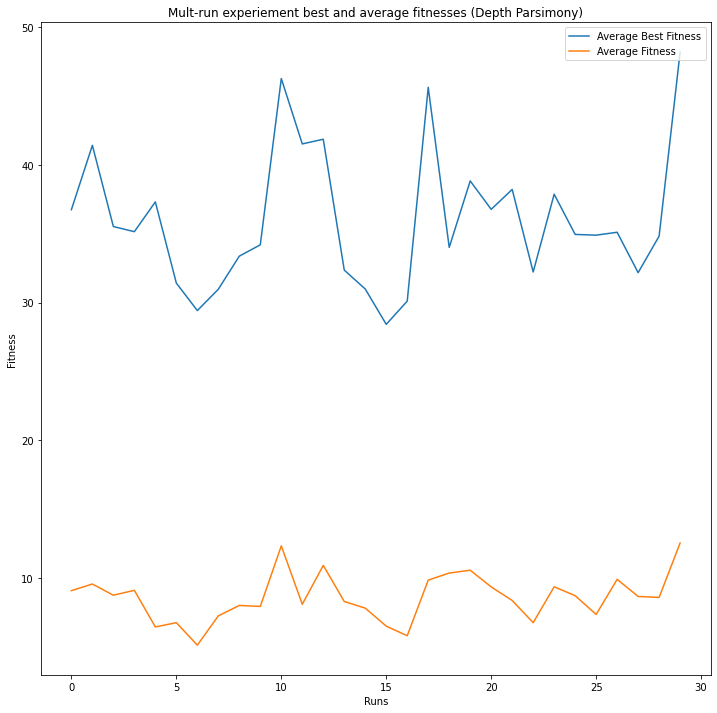

In [47]:
number_runs = 30
number_evaluations = 2000
config_filename = './configs/yellow2b_config.txt'

runsData = list()

# tuning runs can be called here

for runCount in range(number_runs):
    print(f'Run # {runCount}')
    runsData.append(genetic_programming_search(number_evaluations, config_filename, runCount))
    
runsDataBestFitnesses = [runData[0] for runData in runsData]
overallBestFitness = max(runsDataBestFitnesses)

runsDataBestRawFitnesses = [runData[2].raw_fitness for runData in runsData]
          
runsDataBestLogs = [runData[1] for runData in runsData]
overallBestLog = runsDataBestLogs[runsDataBestFitnesses.index(overallBestFitness)]
          
runsDataBestTrees = [runData[2] for runData in runsData]
overallBestTree = runsDataBestTrees[runsDataBestFitnesses.index(overallBestFitness)]

runsDataAveFitnesses = [runData[3] for runData in runsData]
runsDataAveBestFitnesses = [runData[4] for runData in runsData]

print(f'Overall Best Fitness(penalized): {overallBestFitness}')

game_log_path = 'worldFiles/overallBestYellowDepthParsimony.txt'
with open(game_log_path, 'w') as f:
    [f.write(f'{line}\n') for line in overallBestLog]
          
print('Best Tree')
#print(overallBestTree.print())
with open(f'solutions/bestYellowDepthParsimonyRunTree.txt','w') as f:
    f.write(overallBestTree.print())

with open('./data/yellow/depth_parsimony/bestRawFitnesses.txt', 'w') as fp:
    for fitness in runsDataBestRawFitnesses:
        fp.write(f'{fitness}\n')

plt.figure()
plt.title(f'Mult-run experiement best and average fitnesses (Depth Parsimony)')
plt.xlabel('Runs')
plt.ylabel('Fitness')
plt.plot(range(number_runs), runsDataAveBestFitnesses, label="Average Best Fitness")
plt.plot(range(number_runs), runsDataAveFitnesses, label="Average Fitness")
plt.legend(loc="upper right")


# RED Deliverables (Bonus)
For each RED deliverable you attempt, create new notebook cells as necessary and do not overwrite or break compatibility with your previous experimentation. Bonus RED deliverables are typically somewhat open-ended, but this is particularly true in Assignment Series 2. As such, you may encounter unanticipated design decisions and obstacles that you should figure out how to overcome. TA assistance is available to answer questions, though you are expected to experiment and investigate solutions/answers prior to seeking this assistance. You are welcome to re-use tuned parameters between these experiments instead of more rigorous tuning, though you may observe more interesting results with per-deliverable tuning. Finally, the components implemented for the Assignment 2b RED deliverables may reappear in RED deliverables of Assignment 2c. The RED deliverables for Assignment 2c are undecided, but recall that Assignment 2c is worth double points and percentage-based bonuses are consequently quite valuable to the overall Assignment Series 2 grade.

***Note***: When attempting deliverables RED 3 and 4, feel free to use the provided random Pac-Man controller as the static agent.

Create cells below to perform your RED deliverable experiments.

## Red 1 Multiple Identical Pac-Man Controllers

For this section I added the 'M' token to the sensor nodes to represent the distance between one player and the other players. I also added this to the tree_check.py file so that my trees would pass check when running through the whole notebook. 

#### Red 1 full run cell

Run # 0
Run # 1
Run # 2
Run # 3
Run # 4
Run # 5
Run # 6
Run # 7
Run # 8
Run # 9
Run # 10
Run # 11
Run # 12
Run # 13
Run # 14
Run # 15
Run # 16
Run # 17
Run # 18
Run # 19
Run # 20
Run # 21
Run # 22
Run # 23
Run # 24
Run # 25
Run # 26
Run # 27
Run # 28
Run # 29
Overall Best Fitness(penalized): 111
Best Tree


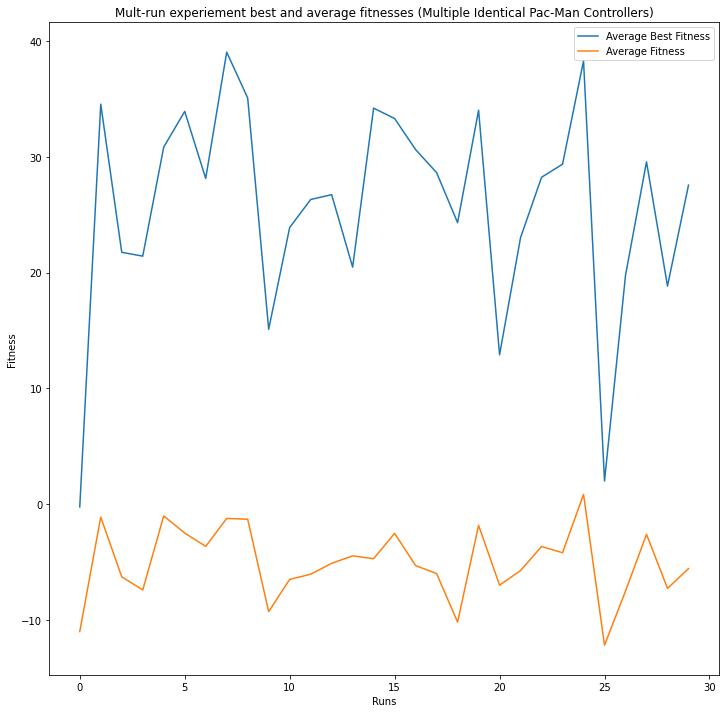

In [49]:
number_runs = 30
number_evaluations = 2000
config_filename = './configs/red1_2b_config.txt'

runsData = list()

for runCount in range(number_runs):
    print(f'Run # {runCount}')
    runsData.append(genetic_programming_search(number_evaluations, config_filename, runCount))
    
runsDataBestFitnesses = [runData[0] for runData in runsData]
overallBestFitness = max(runsDataBestFitnesses)

runsDataBestRawFitnesses = [runData[2].raw_fitness for runData in runsData]
          
runsDataBestLogs = [runData[1] for runData in runsData]
overallBestLog = runsDataBestLogs[runsDataBestFitnesses.index(overallBestFitness)]
          
runsDataBestTrees = [runData[2] for runData in runsData]
overallBestTree = runsDataBestTrees[runsDataBestFitnesses.index(overallBestFitness)]

runsDataAveFitnesses = [runData[3] for runData in runsData]
runsDataAveBestFitnesses = [runData[4] for runData in runsData]

print(f'Overall Best Fitness(penalized): {overallBestFitness}')

game_log_path = 'worldFiles/overallBestRed1.txt'
with open(game_log_path, 'w') as f:
    [f.write(f'{line}\n') for line in overallBestLog]
          
print('Best Tree')
#print(overallBestTree.print())
with open(f'solutions/bestRed1Tree.txt','w') as f:
    f.write(overallBestTree.print())

with open('./data/redOne/bestRawFitnesses.txt', 'w') as fp:
    for fitness in runsDataBestRawFitnesses:
        fp.write(f'{fitness}\n')

plt.figure()
plt.title(f'Mult-run experiement best and average fitnesses (Multiple Identical Pac-Man Controllers)')
plt.xlabel('Runs')
plt.ylabel('Fitness')
plt.plot(range(number_runs), runsDataAveBestFitnesses, label="Average Best Fitness")
plt.plot(range(number_runs), runsDataAveFitnesses, label="Average Fitness")
plt.legend(loc="upper right")


### Red 3 Multiple Identical Ghost Controllers

Files created for this experiment:

- ghost_parse_tree.py
- ghost_tree_genotype.py

I also created a copy of basic_population_evaluation, called ghost_basic_population_evaluation that calculated the individual's raw fitness using the negative game score plus remaining game time specified in the directions. Number of nodes in tree was used as the parimony pressure metric.

In [14]:
from gpac_population_evaluation import ghost_basic_population_evaluation
from ghost_tree_genotype import *
from ghost_parse_tree import *


# implement your GP here
def ghost_genetic_programming_search(number_evaluations, config_filename, run_number):
    best_fitness = -inf
    best_log = None
    best_tree = None
    data = []
    
    # Parse the config and implement your EA here.
    # Feel free to focus on implementation first and then return for data collection.
    
    config = read_config(config_filename, globalVars=globals(), localVars=locals())

    # full initialization of your GP population
    example_EA = GeneticProgrammingPopulation(**config['EA_configs'], **config)
    ghost_basic_population_evaluation(example_EA.population, **config['fitness_kwargs'])
    example_EA.evaluations = len(example_EA.population)
    fitnesses = [individual.fitness for individual in example_EA.population]
    
    data.append([statistics.mean(fitnesses), max(fitnesses)])

    with open('./data/redThree/run' + str(run_number) + 'Data.txt', 'w') as fp:
        fp.write(f'Number of Evaluations: {example_EA.evaluations}\n')
        fp.write(f'Best Fitness: {max(fitnesses)}\n')
        fp.write(f'Average Fitness: {statistics.mean(fitnesses)}\n')
        fp.write('------------------------\n')
    
    #print(f'Average fitness of population: {statistics.mean(fitnesses)}')
    #print(f'Best fitness in population: {max(fitnesses)}')
    #print(f'Number of fitness evaluations: {example_EA.evaluations}')
    
    while not(example_EA.evaluations >= number_evaluations):
        
        # generate children
        children = example_EA.generate_children()
        ghost_basic_population_evaluation(children, **config['fitness_kwargs'])
        example_EA.evaluations += len(children)
        children_fitnesses = [individual.fitness for individual in children]
        
        if(max(children_fitnesses) > best_fitness):
            best_fitness = max(children_fitnesses)
            best_log = children[children_fitnesses.index(best_fitness)].log
            best_tree = children[children_fitnesses.index(best_fitness)]
            #print(f'\tNew best fitness: {best_fitness}')
            #print(f'\tRaw Fitness: {best_tree.raw_fitness}')
        
        data.append([statistics.mean(children_fitnesses), max(children_fitnesses)])
        
        with open('./data/redThree/run' + str(run_number) + 'Data.txt', 'a') as fp:
            fp.write(f'Number of Evaluations: {example_EA.evaluations}\n')
            fp.write(f'Best Fitness: {max(children_fitnesses)}\n')
            fp.write(f'Average Fitness: {statistics.mean(children_fitnesses)}\n')
            fp.write('------------------------\n')
        
        
        #print(f'Average fitness of population: {statistics.mean(children_fitnesses)}')
        #print(f'Best fitness in population: {max(children_fitnesses)}')
        #print(f'Number of fitness evaluations: {example_EA.evaluations}')
        #print('-------------------')
            
    #game_log_path = 'worldFiles/testSingleRun.txt'
    #with open(game_log_path, 'w') as f:
    #    [f.write(f'{line}\n') for line in best_log]
        
    #print('Best Tree')
    #print(best_tree.print())
    
    overallAverageFitness = statistics.mean([gen[0] for gen in data])
    overallAverageBestFitness = statistics.mean([gen[1] for gen in data])
    
    return best_fitness, best_log, best_tree, overallAverageFitness, overallAverageBestFitness

In [36]:
# testing 
ghost_genetic_programming_search(2000, './configs/red3_2b_config.txt', 0)

Average fitness of population: 215.28
Best fitness in population: 1159
Number of fitness evaluations: 50
	New best fitness: 1260
	Raw Fitness: 1268
Number of fitness evaluations: 57
-------------------
Number of fitness evaluations: 64
-------------------
Number of fitness evaluations: 71
-------------------
Number of fitness evaluations: 78
-------------------
	New best fitness: 1277
	Raw Fitness: 1285
Number of fitness evaluations: 85
-------------------
Number of fitness evaluations: 92
-------------------
Number of fitness evaluations: 99
-------------------
Number of fitness evaluations: 106
-------------------
Number of fitness evaluations: 113
-------------------
Number of fitness evaluations: 120
-------------------
	New best fitness: 1293
	Raw Fitness: 1301
Number of fitness evaluations: 127
-------------------
Number of fitness evaluations: 134
-------------------
Number of fitness evaluations: 141
-------------------
Number of fitness evaluations: 148
-------------------
Num

Number of fitness evaluations: 1058
-------------------
Number of fitness evaluations: 1065
-------------------
Number of fitness evaluations: 1072
-------------------
Number of fitness evaluations: 1079
-------------------
Number of fitness evaluations: 1086
-------------------
Number of fitness evaluations: 1093
-------------------
Number of fitness evaluations: 1100
-------------------
Number of fitness evaluations: 1107
-------------------
Number of fitness evaluations: 1114
-------------------
Number of fitness evaluations: 1121
-------------------
Number of fitness evaluations: 1128
-------------------
Number of fitness evaluations: 1135
-------------------
Number of fitness evaluations: 1142
-------------------
Number of fitness evaluations: 1149
-------------------
Number of fitness evaluations: 1156
-------------------
Number of fitness evaluations: 1163
-------------------
Number of fitness evaluations: 1170
-------------------
Number of fitness evaluations: 1177
------------

(1333,
 ['35',
  '20',
  'm 0 19',
  '0 34 0',
  '1 34 0',
  '2 34 0',
  'w 0 5',
  'w 0 6',
  'w 0 7',
  'w 0 8',
  'w 1 1',
  'w 1 2',
  'w 1 3',
  'w 1 10',
  'w 1 11',
  'w 1 12',
  'w 1 13',
  'w 1 15',
  'w 1 17',
  'w 1 18',
  'w 2 1',
  'w 2 5',
  'w 2 6',
  'w 2 7',
  'w 2 8',
  'w 2 13',
  'w 2 15',
  'w 2 17',
  'w 2 18',
  'w 3 1',
  'w 3 3',
  'w 3 4',
  'w 3 5',
  'w 3 6',
  'w 3 7',
  'w 3 8',
  'w 3 9',
  'w 3 10',
  'w 3 11',
  'w 3 13',
  'w 3 17',
  'w 3 18',
  'w 4 3',
  'w 4 4',
  'w 4 5',
  'w 4 6',
  'w 4 7',
  'w 4 8',
  'w 4 9',
  'w 4 10',
  'w 4 11',
  'w 4 15',
  'w 5 1',
  'w 5 2',
  'w 5 3',
  'w 5 4',
  'w 5 5',
  'w 5 6',
  'w 5 7',
  'w 5 8',
  'w 5 9',
  'w 5 10',
  'w 5 11',
  'w 5 12',
  'w 5 14',
  'w 5 15',
  'w 5 16',
  'w 5 18',
  'w 6 3',
  'w 6 4',
  'w 6 5',
  'w 6 6',
  'w 6 7',
  'w 6 8',
  'w 6 9',
  'w 6 10',
  'w 6 11',
  'w 6 12',
  'w 6 14',
  'w 6 15',
  'w 6 16',
  'w 6 18',
  'w 7 1',
  'w 7 3',
  'w 7 4',
  'w 7 5',
  'w 7 6',
  'w 

### Red 3 Full Run

Run # 0
Run # 1
Run # 2
Run # 3
Run # 4
Run # 5
Run # 6
Run # 7
Run # 8
Run # 9
Run # 10
Run # 11
Run # 12
Run # 13
Run # 14
Run # 15
Run # 16
Run # 17
Run # 18
Run # 19
Run # 20
Run # 21
Run # 22
Run # 23
Run # 24
Run # 25
Run # 26
Run # 27
Run # 28
Run # 29
Overall Best Fitness(penalized): 1338
Best Tree


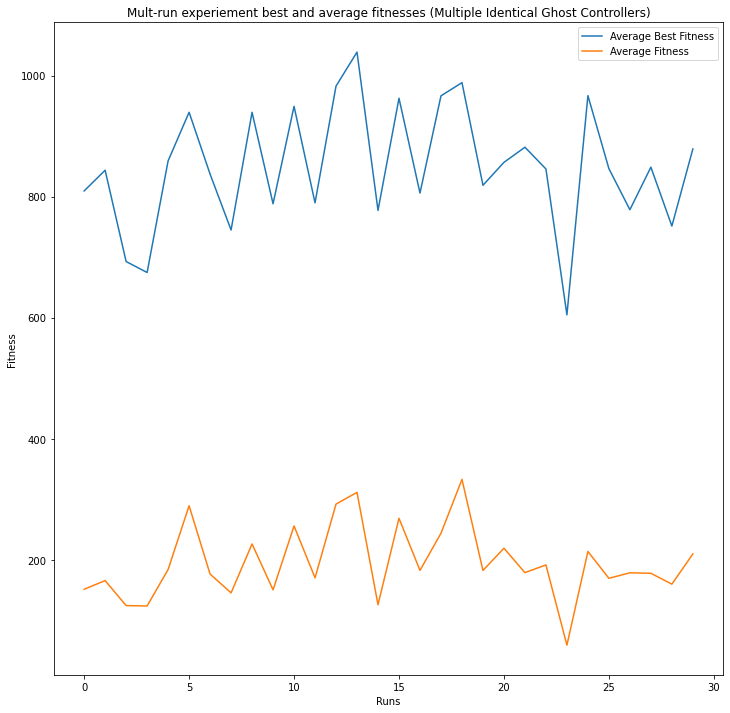

In [15]:
number_runs = 30
number_evaluations = 2000
config_filename = './configs/red3_2b_config.txt'

runsData = list()

for runCount in range(number_runs):
    print(f'Run # {runCount}')
    runsData.append(ghost_genetic_programming_search(number_evaluations, config_filename, runCount))
    
runsDataBestFitnesses = [runData[0] for runData in runsData]
overallBestFitness = max(runsDataBestFitnesses)

runsDataBestRawFitnesses = [runData[2].raw_fitness for runData in runsData]
          
runsDataBestLogs = [runData[1] for runData in runsData]
overallBestLog = runsDataBestLogs[runsDataBestFitnesses.index(overallBestFitness)]
          
runsDataBestTrees = [runData[2] for runData in runsData]
overallBestTree = runsDataBestTrees[runsDataBestFitnesses.index(overallBestFitness)]

runsDataAveFitnesses = [runData[3] for runData in runsData]
runsDataAveBestFitnesses = [runData[4] for runData in runsData]

print(f'Overall Best Fitness(penalized): {overallBestFitness}')

game_log_path = 'worldFiles/overallBestRed3.txt'
with open(game_log_path, 'w') as f:
    [f.write(f'{line}\n') for line in overallBestLog]
          
print('Best Tree')
#print(overallBestTree.print())
with open(f'solutions/bestRed3Tree.txt','w') as f:
    f.write(overallBestTree.print())

with open('./data/redThree/bestRawFitnesses.txt', 'w') as fp:
    for fitness in runsDataBestRawFitnesses:
        fp.write(f'{fitness}\n')

plt.figure()
plt.title(f'Mult-run experiement best and average fitnesses (Multiple Identical Ghost Controllers)')
plt.xlabel('Runs')
plt.ylabel('Fitness')
plt.plot(range(number_runs), runsDataAveBestFitnesses, label="Average Best Fitness")
plt.plot(range(number_runs), runsDataAveFitnesses, label="Average Fitness")
plt.legend(loc="upper right")

# Side Note: Canonical Genetic Programming

Should you apply GP after this class, you should know that the GP algorithm taught in this class (as described in the course textbook) differs somewhat from the algorithm canonically used in GP. Notably, the textbook has certain important omissions regarding the Ramped Half-and-half algorithm and the GP evolutionary cycle. In practice, the Ramped Half-and-half algorithm uses a `grow` method which ensures at least 1 branch reaches the depth limit. This can be difficult to implement, and has little impact on this assignment, so we don't require the implementation of the canonical version of the algorithm.

More importantly, however, is that the canonical GP evolutionary cycle is generational in nature. In the canonical Generational GP algorithm, $\mu$ children are created each generation via recombination, mutation, or *reproduction* and the children directly replace the parents without survival selection. Notably, the reproduction operation involves directly copying the selected parent to the children pool and this enables behavior similar to steady state survival. The algorithm you implement for this assignment series is much more similar to a Genetic Algorithm in nature and you should be aware of this distinction if you continue to work with GP. For more information see [here](https://geneticprogramming.com/about-gp/gp-workflow/).